In [ ]:
!pip3 install scikit-image --user

In [13]:
import os
import keras
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import model_from_json

import matplotlib.pyplot as plt
import itertools
from skimage import transform
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
"""
    Preprocess image, normalizing and resizing it

    :param frame: RGBA frame
"""    
def preprocess_image(frame):
    
    # Normalize Pixel Values
    normalized_frame = frame/255.0 - 0.5
    
    # Resize
    preprocessed_frame = transform.resize(normalized_frame, IMAGE_PP_SIZE)
    
    # Create a 3-Channel image
    final_image = np.dstack((preprocessed_frame, preprocessed_frame, preprocessed_frame))
    
    return final_image

"""
    Create 2D label list from 1D list
    
    :param labels: 1D label list
"""

def make_labels(labels):
    np_labels = np.zeros((len(labels), 16))
    
    for i in range(len(labels)):
        np_labels[i, labels[i]] = 1
    
    return np_labels

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def choices(l, k=1):
    new_list = []
    for i in range(k):
        new_list.append(random.choice(l))
    return new_list

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     print(cm)
    
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Define Globals

In [3]:
IMAGE_PP_SIZE = [150, 150]
EPOCHS = 10
BATCH_SIZE = 100
TRAIN_STEP = 5000
VAL_SIZE = 1000

RELOAD_MODEL = True

## Load Model if it Exists, Otherwise Recreate it

In [4]:
if RELOAD_MODEL:
    try:
        json_file = open('model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        model.load_weights("model.h5")
    except:

        model = Sequential()
        model.add(Conv2D(20, kernel_size=(7, 7), strides=(1, 1),
                         activation='relu',
                         input_shape=(IMAGE_PP_SIZE[0], IMAGE_PP_SIZE[1], 1)))
        model.add(MaxPooling2D(pool_size=(4, 4), strides=(1, 1)))
        model.add(Conv2D(50, kernel_size = (5, 5), activation='relu'))
        model.add(MaxPooling2D(pool_size=(4, 4)))
        model.add(Flatten())
        model.add(Dense(1000, activation='relu'))
        model.add(Dense(1000, activation='relu'))
        model.add(Dense(16, activation='softmax'))
else:
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(7, 7), strides=(1, 1),
                     activation='relu',
                     input_shape=(IMAGE_PP_SIZE[0], IMAGE_PP_SIZE[1], 1)))
    model.add(MaxPooling2D(pool_size=(4, 4), strides=(1, 1)))
    model.add(Conv2D(50, kernel_size = (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(16, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [5]:

#
# Define train, validation and test lists
#

train_labels = []
val_labels = []
test_labels = []

train_input = []
val_input = []
test_input = []

#
# Load validation dataset
#

folder = "/media/matheusmortatti/External/rvl-cdip"
labels_file = open(folder + "/labels/val.txt")

val_file = []
for line in labels_file:
    sp = line.split()
    val_file.append(sp)
    
#
# Open training list file and start training
#


trained = 0
train_size = file_len(folder + "/labels/train.txt")

for i in range(EPOCHS):
    labels_file = open(folder + "/labels/train.txt")
    for line in labels_file:
        sp = line.split()
        pp_img = preprocess_image(imread(folder + "/images/" + sp[0]))

        train_input.append(pp_img)
        train_labels.append(int(sp[1]))

        if len(train_input) >= TRAIN_STEP:
            
            trained += len(train_input)

            #
            # Choose a subset of the validation data
            #

            ss_val = choices(val_file, k=VAL_SIZE)

            for v in ss_val:
                val_input.append(preprocess_image(imread(folder + "/images/" + v[0])))
                val_labels.append(int(v[1]))

            x_val = np.expand_dims(np.asarray(val_input), axis=3)
            y_val = make_labels(val_labels)

            #
            # Create training data
            #

            x_train = np.expand_dims(np.asarray(train_input), axis=3)
            y_train = make_labels(train_labels)

            model.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=1,
                      verbose=1,
                      validation_data=(x_val, y_val))

            #
            # Reset lists for next iteration
            #

            train_input = []
            train_labels = []
            val_input = []
            val_labels = []
            
            print("trained: " + str(trained) + " / " + str(train_size))
    labels_file.close()


/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 15s 3ms/step - loss: 0.4651 - acc: 0.8604 - val_loss: 0.6983 - val_acc: 0.7970
trained: 5000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.4563 - acc: 0.8678 - val_loss: 0.6987 - val_acc: 0.8050
trained: 10000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.4379 - acc: 0.8698 - val_loss: 0.6647 - val_acc: 0.8050
trained: 15000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 13s 3ms/step - loss: 0.4086 - acc: 0.8766 - val_loss: 0.6142 - val_acc: 0.8090
trained: 20000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 13s 3ms/step - loss: 0.3883 - acc: 0.8838 - val_loss: 0.7852 - val_acc: 0.

5000/5000 [==============================] - 12s 2ms/step - loss: 0.4511 - acc: 0.8670 - val_loss: 0.6963 - val_acc: 0.7970
trained: 200000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.4657 - acc: 0.8598 - val_loss: 0.6620 - val_acc: 0.8200
trained: 205000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.4356 - acc: 0.8650 - val_loss: 0.6446 - val_acc: 0.8100
trained: 210000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.4519 - acc: 0.8656 - val_loss: 0.6872 - val_acc: 0.8040
trained: 215000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.4843 - acc: 0.8518 - val_loss: 0.6533 - val_acc: 0.8140
trained: 220000 / 320000
Train on 5000 samples, 

trained: 395000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.2077 - acc: 0.9432 - val_loss: 0.7493 - val_acc: 0.7900
trained: 400000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.2078 - acc: 0.9388 - val_loss: 0.6825 - val_acc: 0.8140
trained: 405000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1958 - acc: 0.9418 - val_loss: 0.6697 - val_acc: 0.8190
trained: 410000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1858 - acc: 0.9464 - val_loss: 0.6669 - val_acc: 0.8170
trained: 415000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1819 - acc: 0.9452 - 

5000/5000 [==============================] - 12s 2ms/step - loss: 0.3112 - acc: 0.9098 - val_loss: 0.6865 - val_acc: 0.8140
trained: 595000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.2945 - acc: 0.9134 - val_loss: 0.6356 - val_acc: 0.8230
trained: 600000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.3224 - acc: 0.9028 - val_loss: 0.6737 - val_acc: 0.8040
trained: 605000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.3286 - acc: 0.9012 - val_loss: 0.6543 - val_acc: 0.8180
trained: 610000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.2940 - acc: 0.9110 - val_loss: 0.6509 - val_acc: 0.8130
trained: 615000 / 320000
Train on 5000 samples, 

trained: 790000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.2803 - acc: 0.9176 - val_loss: 0.6030 - val_acc: 0.8370
trained: 795000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.3089 - acc: 0.9124 - val_loss: 0.6193 - val_acc: 0.8190
trained: 800000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.2844 - acc: 0.9172 - val_loss: 0.6988 - val_acc: 0.8050
trained: 805000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.2766 - acc: 0.9202 - val_loss: 0.6665 - val_acc: 0.8060
trained: 810000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.2906 - acc: 0.9140 - 

5000/5000 [==============================] - 12s 2ms/step - loss: 0.1529 - acc: 0.9610 - val_loss: 0.7454 - val_acc: 0.8080
trained: 990000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1274 - acc: 0.9678 - val_loss: 0.6935 - val_acc: 0.8200
trained: 995000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1522 - acc: 0.9608 - val_loss: 0.7697 - val_acc: 0.7980
trained: 1000000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1259 - acc: 0.9668 - val_loss: 0.7647 - val_acc: 0.8010
trained: 1005000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1215 - acc: 0.9670 - val_loss: 0.7688 - val_acc: 0.8180
trained: 1010000 / 320000
Train on 5000 sample

trained: 1185000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1527 - acc: 0.9624 - val_loss: 0.8114 - val_acc: 0.7950
trained: 1190000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1616 - acc: 0.9592 - val_loss: 0.7263 - val_acc: 0.8000
trained: 1195000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1570 - acc: 0.9606 - val_loss: 0.6338 - val_acc: 0.8390
trained: 1200000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1539 - acc: 0.9592 - val_loss: 0.6730 - val_acc: 0.8160
trained: 1205000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1731 - acc: 0.95

5000/5000 [==============================] - 12s 2ms/step - loss: 0.0521 - acc: 0.9922 - val_loss: 0.8126 - val_acc: 0.8180
trained: 1385000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0495 - acc: 0.9890 - val_loss: 0.9392 - val_acc: 0.8010
trained: 1390000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0459 - acc: 0.9918 - val_loss: 1.0069 - val_acc: 0.7980
trained: 1395000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0448 - acc: 0.9910 - val_loss: 1.0275 - val_acc: 0.7920
trained: 1400000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0526 - acc: 0.9868 - val_loss: 0.8560 - val_acc: 0.8160
trained: 1405000 / 320000
Train on 5000 samp

5000/5000 [==============================] - 12s 2ms/step - loss: 0.0967 - acc: 0.9788 - val_loss: 0.7340 - val_acc: 0.8200
trained: 1580000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0828 - acc: 0.9842 - val_loss: 0.9261 - val_acc: 0.7870
trained: 1585000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0692 - acc: 0.9850 - val_loss: 0.9290 - val_acc: 0.8150
trained: 1590000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0837 - acc: 0.9816 - val_loss: 0.8676 - val_acc: 0.8090
trained: 1595000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0759 - acc: 0.9846 - val_loss: 0.7212 - val_acc: 0.8220
trained: 1600000 / 320000
Train on 5000 samp

5000/5000 [==============================] - 12s 2ms/step - loss: 0.0588 - acc: 0.9870 - val_loss: 0.9765 - val_acc: 0.8100
trained: 1775000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0509 - acc: 0.9908 - val_loss: 0.7974 - val_acc: 0.8250
trained: 1780000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0522 - acc: 0.9880 - val_loss: 1.0163 - val_acc: 0.8110
trained: 1785000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0531 - acc: 0.9888 - val_loss: 0.9222 - val_acc: 0.8110
trained: 1790000 / 320000
Train on 5000 samples, validate on 1000 samples
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0509 - acc: 0.9892 - val_loss: 0.8320 - val_acc: 0.8180
trained: 1795000 / 320000
Train on 5000 samp

KeyboardInterrupt: 

## Save Model and Weights

In [6]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [9]:
folder = "/media/matheusmortatti/External/rvl-cdip"
labels_file = open(folder + "/labels/val.txt")

x_val = []
y_val = []
y_pred_total = np.array([])

for line in labels_file:
    sp = line.split()
    x_val.append(preprocess_image(imread(folder + "/images/" + sp[0])))
    y_val.append(int(sp[1]))
    
    if len(x_val) >= 5000:
        
        #
        # Predict validation classes
        #
        
        x_val = np.expand_dims(np.asarray(x_val), axis=3)
        y_pred = model.predict_classes(x_val)
        y_pred_total = np.append(y_pred_total, y_pred)
        print(y_pred_total.shape)
        x_val = []
        
if len(x_val) > 0:
        
    #
    # Predict validation classes
    #

    x_val = np.expand_dims(np.asarray(x_val), axis=3)
    y_pred = model.predict_classes(x_val)
    y_pred_total = np.append(y_pred_total, y_pred)
    print(y_pred_total.shape)
    x_val = []
        

/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(5000,)
(10000,)
(15000,)
(20000,)
(25000,)
(30000,)
(35000,)
(40000,)


In [10]:
y_val = np.asarray(y_val)
print('Confusion Matrix')
print(confusion_matrix(y_val, y_pred_total))
print(classification_report(y_val, y_pred_total))

Confusion Matrix
[[1906   77   20   38   18   35   10   14   11   16   19   39   30   43
    24  130]
 [  78 1723    9   32   27  105   13   66   31    8  104  130   27  114
    12   58]
 [  24   10 2404    3    4   11    2    7    4    8    9    2    7   15
    10   10]
 [  21   43    0 2175   34   12    4   15   12    5   20   31    8   45
     2    7]
 [  13   15    3   23 2182   19   21    6   38   78   20   17   42   29
     4   12]
 [  46  134    8   19   12 1571   90   40   47   39  124   42  155   66
    42   73]
 [  11   22    4    2   28   69 2177    7   21   98   13    8   21   21
    14   10]
 [  23   88    4   16   12   41   13 2156    8    9   56   27    6   44
     8   20]
 [   2   21    2    8   43   32    7    2 2229    8   14   13   47   10
     5    8]
 [  25   18   13    4  102   33  119    7   13 2045   16   14   52   27
    15   23]
 [  14   82    5   14   10  122    5   41   24   17 1873   92   69   64
    18   35]
 [  58  152    4   28   13   48   11   21   18  

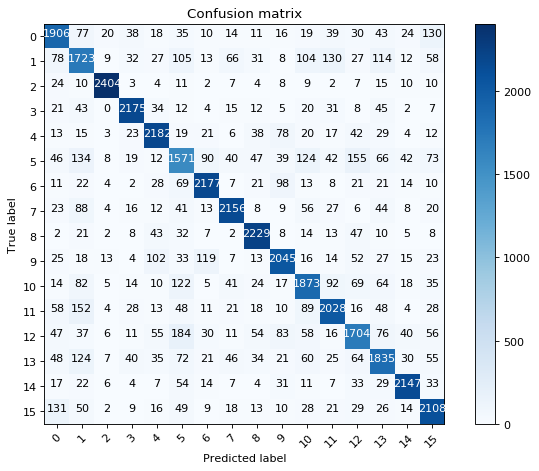

In [15]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred_total), np.arange(16))